In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import operator
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import math 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms

In [2]:
df = pd.read_csv("time_series_covid_19_confirmed.csv", sep=",")
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20,5/27/20,5/28/20,5/29/20,5/30/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,8676,9216,9998,10582,11173,11831,12456,13036,13659,14525
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,969,981,989,998,1004,1029,1050,1076,1099,1122
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,7728,7918,8113,8306,8503,8697,8857,8997,9134,9267
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,762,762,762,762,763,763,763,763,764,764
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,58,60,61,69,70,70,71,74,81,84


## Finding Similiar Countries

In [3]:

county1=df.set_index('Country/Region').iloc[:,3:-3]
#Finding dataframe needed to calculate corelation
coun = county1.loc[:,'2/26/20':'5/10/20']
county1=county1.T
countries=coun.index.drop_duplicates()
coun=coun.T
pak_data=coun['Pakistan']
correlation={}
for country in countries:
    #Summing the data for countries that have provinces
    dfr1=coun[country]
    if isinstance(dfr1,pd.core.series.Series):
            x_ax=dfr1
        
    else:
            x_ax=dfr1.sum(axis=1)
    
    #For countries having cases more than 20000
    if (x_ax['5/10/20'] > 20000):
        corr=np.corrcoef(pak_data,x_ax )
        correlation[country]=corr[0][1]

# Sorting Countries
sort_corr = sorted(correlation.items(), key=operator.itemgetter(1),reverse=True)
selected_countries=['Pakistan']
for i in range(5):
    print(sort_corr[i+1][0],sort_corr[i+1][1])
    selected_countries.append(sort_corr[i+1][0])


India 0.9976172372044213
Mexico 0.9974640778447007
Brazil 0.9973183087147551
Qatar 0.9965421674432555
Saudi Arabia 0.995875821968421


## Processing Data

In [4]:
def prepare_data(country,window,string= None):
    train=[]
    label=[]
    data=[]
    country_data=county1[country]
    prev_cases=0
    
    #Calculating daily cases for each day
    for dta in country_data:
        if (dta > 0):
            if string=='rnn':
                data.append([dta-prev_cases])
            else:
                data.append(dta-prev_cases)
            prev_cases=dta
    if (string == 'rnn'):
        scaler = MinMaxScaler()
        scaler.fit(data)
        data = scaler.transform(data)
  
    #Creating sequence of the size window
    for i in range(len(data)-window-1):
        x = data[i:(i+window)]
        y = data[i+window]
        train.append(x)
        label.append(y)
    if string=='rnn':
        return torch.tensor(train), torch.tensor(label), scaler
    
    return train,label

In [5]:
def accuracy(y_true,y_pred):
    mse=mean_squared_error(y_true, y_pred)
    return math.sqrt(mse)

In [6]:
last_day = -17
window = 5
Future = 31
days=[]
day = 11
pred_days=[]
for i in range(17):
    days.append(day+i)
for i in range(31):
    pred_days.append(i+1)

## Training and Testing MLP

In [7]:
xtest,ytest = prepare_data('Pakistan',5)
xtest = xtest[-17:]
ytest = ytest[-17:]

country_pred={}
month_pred={}
for country in selected_countries:
    #Initializing MLP from SKlearn
    clf = MLPClassifier(hidden_layer_sizes=(100,100,100),max_iter=1000)
    #Processing Data
    train,label=prepare_data(country,5)
    trainx = train[:-17]
    labelx = label[:-17]
    clf.fit(trainx,labelx)
    predicted=clf.predict(xtest)
    
    #Entering the predicted data for 17 days in a dictionary
    country_pred[country] = predicted
    # Calculating RMSE error
    print(country,accuracy(ytest,predicted))
    
    #Taking last sequence to use to predict for next month
    test_seq = [xtest[-1]]
    preds = []
    for _ in range(Future):
        pred = clf.predict(test_seq)
        preds.append(pred)
        new_seq = np.append(test_seq, pred)
        test_seq = new_seq[1:].reshape(1,window)
    #Adding predictions to a dictionary
    month_pred[country] = preds
        

Pakistan 1682.6636796530463
India 1607.2752793250481
Mexico 1704.8154807865312
Brazil 2007.538864908385
Qatar 1628.6040395526038
Saudi Arabia 1687.0921206411379


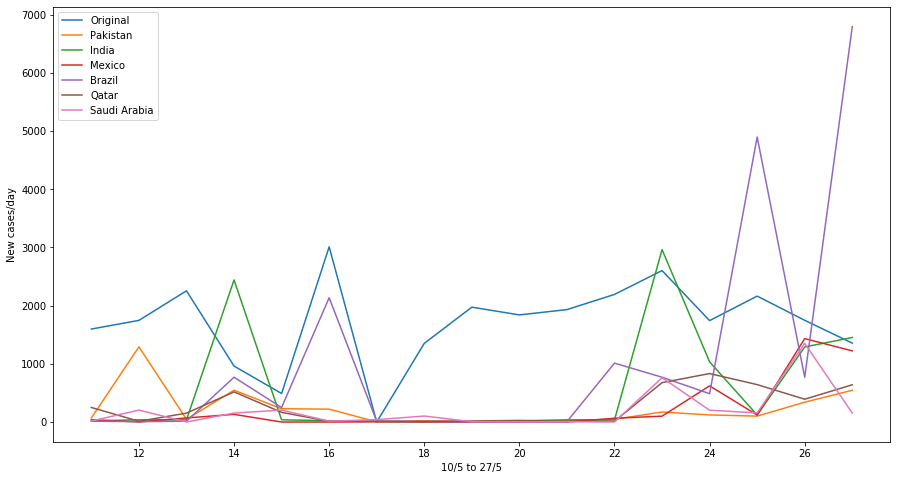

In [8]:
__, pak_label=prepare_data('Pakistan',5)
pak_label = pak_label[-17:]
plt.rcParams['figure.figsize']=(15,8)
plt.plot(days,pak_label)
legend=['Original']
for data in country_pred:
    plt.plot(days,country_pred[data])
    legend.append(data)
plt.legend(legend)
plt.xlabel('10/5 to 27/5')
plt.ylabel('New cases/day')
plt.show()

In [9]:
class RNN(nn.Module):
    def __init__(self, n_layers, n_inputs, n_neurons, n_outputs, seq_length):
        super(RNN, self).__init__()
        
        #Initializing variables and layers
        self.n_neurons = n_neurons
        self.n_layers = n_layers
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.seq_len = seq_length
        
        self.basic_rnn = nn.RNN(self.n_inputs, self.n_neurons, self.n_layers) 
        
        self.FC = nn.Linear(self.n_neurons, self.n_outputs)
        
    def init_hidden(self,):
        # (num_layers, batch_size, n_neurons)
         
        self.hidden = torch.zeros(self.n_layers, self.seq_len, self.n_neurons)
        
        
    def forward(self, X):
    
        lstm_out, self.hidden = self.basic_rnn(X, self.hidden)      
        out = self.FC(lstm_out.view(self.seq_len, len(X), self.n_neurons)[-1])
        return out

In [10]:
SEQ_LENGTH = 5
N_STEPS = 3
N_INPUTS = 1
N_NEURONS = 100
N_OUTPUTS = 1

## Training and Testing LSTM

In [11]:
country_predrnn={}
month_predrnn = {}

xtest,ytest,scaler_ex = prepare_data('Pakistan',5,'rnn')
xtest = xtest[-17:]
ytest = ytest[-17:]

ytest = scaler_ex.inverse_transform(ytest.detach().numpy())

for country in selected_countries:
    #Initailizing model and parameters
    model = RNN(N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS, SEQ_LENGTH)
    criterion = nn.MSELoss(reduction='sum')
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    
    #preparing data
    trainX,trainy,scaler=prepare_data(country ,5, 'rnn')
    xtrain = trainX[:-17]
    ytrain = trainy[:-17]
    
    #Training the model on data
    for epoch in range(500): 
        model.train()
        model.hidden = model.init_hidden()
        output = model(xtrain.float())
        loss = criterion(output.float(), ytrain.float())
        
        #Print loss after each 20 epochs
        if ((epoch+1)%100==0):
            print('Epoch',epoch+1,'Loss',loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    
    model.eval()
    
    #Predicting for last 17 days of May
    output1 = model(xtest.float())
    
    #Round-up the values
    output1 = np.rint(scaler.inverse_transform(output1.detach().numpy()))
    country_predrnn[country] = output1
    
    #Printing the rmse values
    print(country,accuracy(output1,ytest))
    test_seq = xtest[-1].reshape(1,window,1)
    preds = []
    
    #making predictions for month of june
    for _ in range(Future):
        y_test_pred = model(test_seq.float())
        pred = torch.flatten(y_test_pred).item()
        
        #Reverse the scaling
        pred_new = scaler.inverse_transform([[pred]])[0][0]
        
        #If negative value is predicted that is changed to 0
        if (pred_new < 0):
            pred_new = 0
        preds.append(pred_new)
        
        #Making new sequence for prediction
        new_seq = test_seq.numpy()
        new_seq = np.append(new_seq, pred)
        new_seq = new_seq[1:]
        test_seq = torch.as_tensor(new_seq).view(1, window, 1).float()
    preds = np.rint(preds)
    month_predrnn[country] = preds

Epoch 100 Loss 2.2356534004211426
Epoch 200 Loss 1.8388155698776245
Epoch 300 Loss 1.8385616540908813
Epoch 400 Loss 1.8381319046020508
Epoch 500 Loss 1.8371458053588867
Pakistan 1474.1205553701184
Epoch 100 Loss 1.7445042133331299
Epoch 200 Loss 1.4378037452697754
Epoch 300 Loss 0.25916343927383423
Epoch 400 Loss 0.3348081409931183
Epoch 500 Loss 0.21748627722263336
India 2649.960832118978
Epoch 100 Loss 5.487603664398193
Epoch 200 Loss 1.6523736715316772
Epoch 300 Loss 1.6719094514846802
Epoch 400 Loss 2.031215190887451
Epoch 500 Loss 2.008251667022705
Mexico 1417.199039530813
Epoch 100 Loss 1.4614511728286743
Epoch 200 Loss 1.2987632751464844
Epoch 300 Loss 1.108333945274353
Epoch 400 Loss 1.060570478439331
Epoch 500 Loss 0.1485040783882141
Brazil 1481.4833583866105
Epoch 100 Loss 2.4033560752868652
Epoch 200 Loss 2.3804514408111572
Epoch 300 Loss 2.3801169395446777
Epoch 400 Loss 2.3798108100891113
Epoch 500 Loss 2.3794100284576416
Qatar 1552.526195667981
Epoch 100 Loss 2.592511653

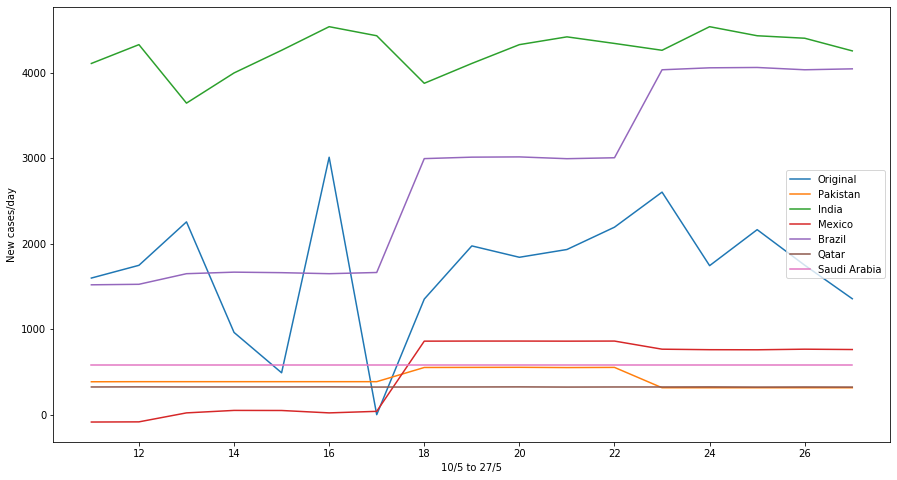

In [12]:
plt.rcParams['figure.figsize']=(15,8)
plt.plot(days,pak_label)
legend=['Original']
for data in country_pred:
    plt.plot(days,country_predrnn[data])
    legend.append(data)
plt.legend(legend)
plt.xlabel('10/5 to 27/5')
plt.ylabel('New cases/day')
plt.show()

## Averaging the prediction from both models

Pakistan


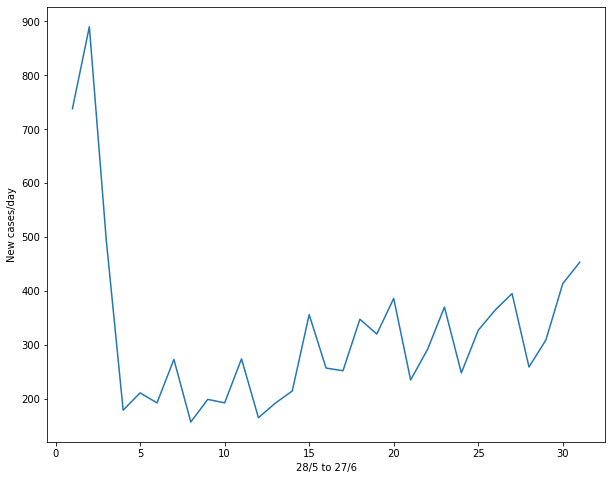

India


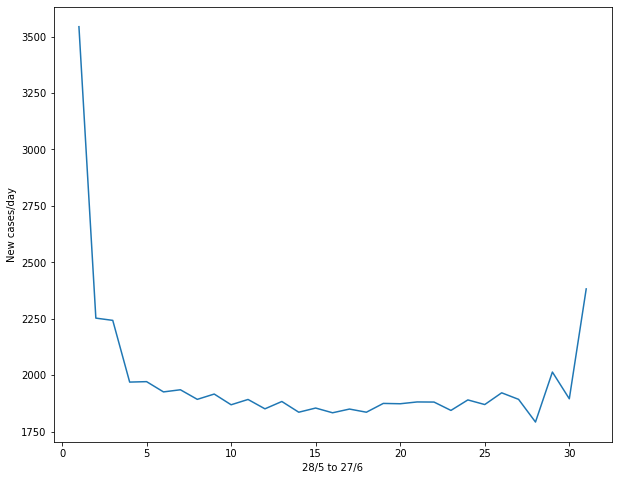

Mexico


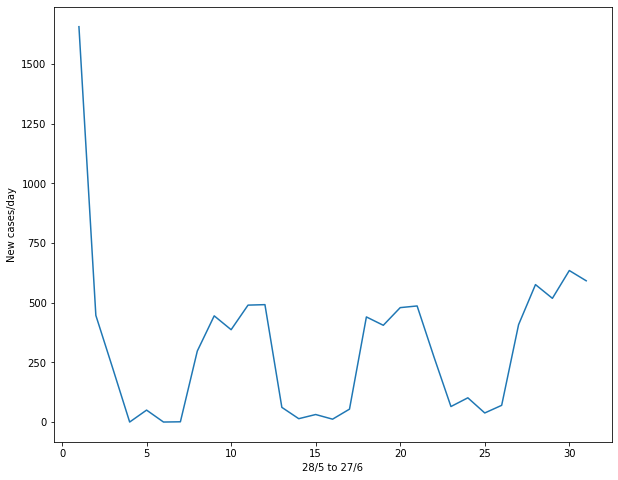

Brazil


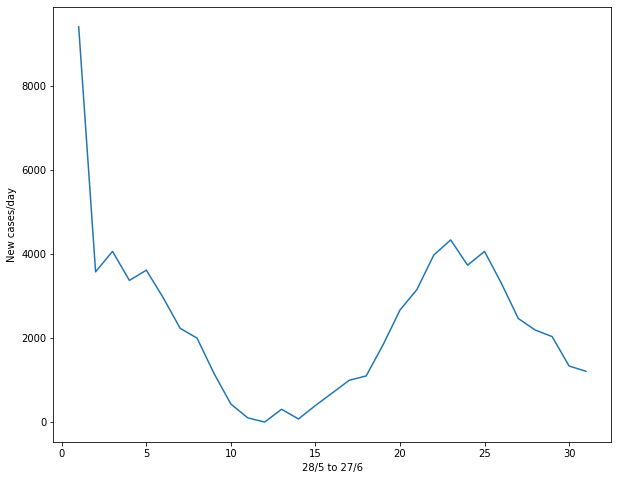

Qatar


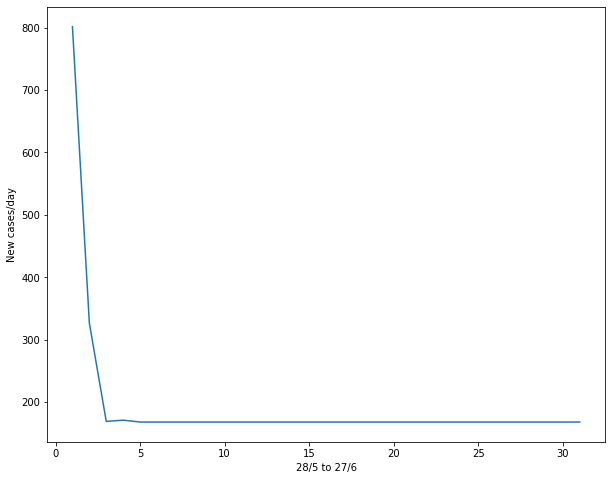

Saudi Arabia


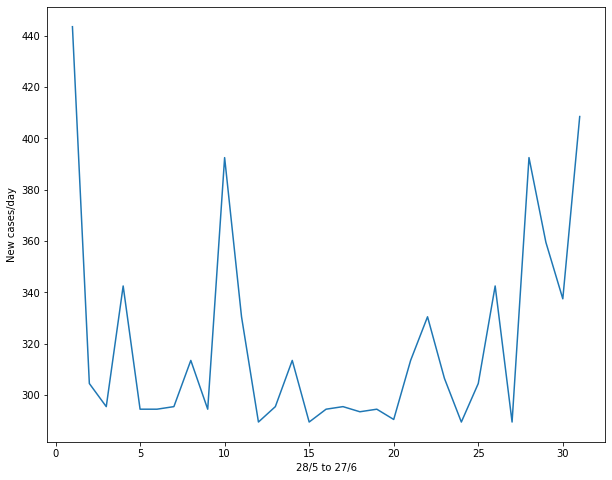

In [13]:

for country in selected_countries:
    new = []
    plt.rcParams['figure.figsize']=(10,8)
    x = month_pred[country]
    for i in range(len(x)):
        dta1 = month_pred[country][i]+month_predrnn[country][i]/2
        new.append(dta1)
    plt.plot(pred_days,new)
    print(country)
    plt.xlabel('28/5 to 27/6')
    plt.ylabel('New cases/day')
    plt.show()
    